In [1]:
'''
Looping through multiple tickers

Trying pycaret regression with monthly S&P features (with beta and rf).
1200 rows
target = 'M1_forward_return'
fold_strategy = 'timeseries'

Dropped market 1 month forward return

'''

"\nLooping through multiple tickers\n\nTrying pycaret regression with monthly S&P features (with beta and rf).\n1200 rows\ntarget = 'M1_forward_return'\nfold_strategy = 'timeseries'\n\n"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycaret
from pycaret.regression import *
#from pycaret.time_series import *

In [3]:
#Tickers to loop over
Ticker_list=["NVDA","META","TSLA","AMZN","GOOG","MSFT","AAPL","GS","JPM","NFLX","NKE","AAL","LUV","GM"]

In [4]:
# Dictionary to store DataFrames
dfs = {}

for ticker in Ticker_list:
    # Replace 'path/to/your/file.csv' with the actual path to your CSV file
    filepath = f'/Users/bennyang/Downloads/{ticker} features.csv'
    
    # Use pandas to read the CSV file
    dfs[ticker] = pd.read_csv(filepath)
    
    # Print the dataframe to verify it was read correctly
    #print(dfs)

In [5]:
#dfs

In [6]:
for i in dfs.values():
    i['Date'] = pd.to_datetime(i['Date'])

In [7]:
#dfs["NVDA"].info()

In [8]:
# Replace 'path/to/your/file.xlsx' with the actual path to your Excel file
Beta_rf = '/Users/bennyang/Downloads/beta&rf.csv'

# Use pandas to read the Excel file
Beta_rf = pd.read_csv(Beta_rf)

# Print the dataframe to verify it was read correctly
print(Beta_rf)

               Date Ticker     US6M      Beta
0        2006-01-03      A  0.04337  1.163252
1        2006-01-03    AAL  0.04337       NaN
2        2006-01-03   AAPL  0.04337  1.770564
3        2006-01-03   ABBV  0.04337       NaN
4        2006-01-03   ABNB  0.04337       NaN
...             ...    ...      ...       ...
2329483  2024-06-11    YUM  0.05372  0.641219
2329484  2024-06-11    ZBH  0.05372  0.720603
2329485  2024-06-11   ZBRA  0.05372  1.507831
2329486  2024-06-11    ZTS  0.05372  1.130680
2329487  2024-06-11  ^GSPC  0.05372  0.002707

[2329488 rows x 4 columns]


In [9]:
#beta= Beta_rf[Beta_rf['Ticker'] == 'NVDA']

In [10]:
#beta.info()

In [11]:
#Extract beta data and combine it with the main dataframe
for key,value in dfs.items():
    beta = Beta_rf[Beta_rf['Ticker'] == f'{key}']
    beta['Date'] = pd.to_datetime(beta['Date'])
    beta.drop('Ticker',axis=1,inplace=True)
    dfs[key]= pd.merge(dfs[key], beta,  how='left', left_on=['Date'], right_on = ['Date'])
    #Drop market 1 month forward return
    dfs[key].drop('Mkt_M1_forward_return',axis=1,inplace=True) 

In [12]:
# Dictionary to store DataFrames
Monthly = {}

for key,value in dfs.items():
    Monthly[key] = dfs[key].resample('M', on='Date').last("D")

In [16]:
#Get the latest features to avoid NA
Latest_Features = {}

#Need to edit the last values as necessary to avoid NA
for key,value in Monthly.items():
    Latest_Features[key]= Monthly[key][-60:-1]


In [17]:
#Latest_Features['NVDA']

,Description,Value
0,Session id,123
1,Target,M1_forward_return
2,Target type,Regression
3,Original data shape,"(59, 40)"
4,Transformed data shape,"(59, 38)"
5,Transformed train set shape,"(41, 38)"
6,Transformed test set shape,"(18, 38)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.1298,0.0240,0.1432,-1.1056,0.0908,1.8033,0.0710
llar,Lasso Least Angle Regression,0.1298,0.0240,0.1432,-1.1056,0.0908,1.8033,0.0040
en,Elastic Net,0.1298,0.0240,0.1432,-1.1056,0.0908,1.8033,0.0040
dummy,Dummy Regressor,0.1298,0.0240,0.1432,-1.1056,0.0908,1.8033,0.0040
lightgbm,Light Gradient Boosting Machine,0.1298,0.0240,0.1432,-1.1056,0.0908,1.8033,0.0070
knn,K Neighbors Regressor,0.1408,0.0277,0.1558,-1.5238,0.0955,2.0065,0.0090
rf,Random Forest Regressor,0.1410,0.0273,0.1537,-1.7031,0.1013,2.1435,0.0160
et,Extra Trees Regressor,0.1467,0.0331,0.1673,-1.8517,0.0887,1.9366,0.0130
ada,AdaBoost Regressor,0.1429,0.0295,0.1589,-1.9424,0.0961,2.0141,0.0080
omp,Orthogonal Matching Pursuit,0.1455,0.0298,0.1626,-2.4353,0.0902,2.2132,0.0040


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0878,0.0106,0.1031,-0.3237,0.0911,1.9142
1,0.0750,0.0077,0.0876,-2.7419,0.0396,2.7779
2,0.0607,0.0056,0.0746,-1.9613,0.0239,1.3002
3,0.0801,0.0094,0.0968,-2.1713,0.0862,0.5225
4,0.1068,0.0121,0.1100,-0.2594,0.0502,2.0028
5,0.1649,0.0274,0.1655,-0.1428,0.1221,1.0251
6,0.1386,0.0248,0.1574,-0.2953,0.0815,3.0456
7,0.2379,0.0764,0.2764,-2.8564,0.1561,3.4318
8,0.1973,0.0407,0.2019,-0.2663,0.1335,1.0866


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.1400,0.0301,0.1735,-0.5965,0.1462,0.9106


,Description,Value
0,Session id,123
1,Target,M1_forward_return
2,Target type,Regression
3,Original data shape,"(59, 40)"
4,Transformed data shape,"(59, 37)"
5,Transformed train set shape,"(41, 37)"
6,Transformed test set shape,"(18, 37)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.0908,0.0185,0.1142,-0.5367,0.0938,1.5019,0.0040
llar,Lasso Least Angle Regression,0.0908,0.0185,0.1142,-0.5367,0.0938,1.5019,0.0040
en,Elastic Net,0.0908,0.0185,0.1142,-0.5367,0.0938,1.5019,0.0050
dummy,Dummy Regressor,0.0908,0.0185,0.1142,-0.5367,0.0938,1.5019,0.0040
lightgbm,Light Gradient Boosting Machine,0.0908,0.0185,0.1142,-0.5367,0.0938,1.5019,0.0070
knn,K Neighbors Regressor,0.0949,0.0180,0.1139,-0.7589,0.0830,7.3878,0.0040
rf,Random Forest Regressor,0.1038,0.0207,0.1214,-0.9252,0.0917,10.3055,0.0160
ada,AdaBoost Regressor,0.1039,0.0194,0.1215,-1.3794,0.0815,6.8699,0.0080
et,Extra Trees Regressor,0.1100,0.0209,0.1283,-1.7010,0.0798,12.8604,0.0120
par,Passive Aggressive Regressor,0.0980,0.0186,0.1223,-1.8622,0.0782,4.6324,0.0040


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0941,0.0113,0.1064,-0.0174,0.0946,0.9276
1,0.0544,0.0033,0.0577,-0.5871,0.0530,1.0967
2,0.0526,0.0042,0.0650,-0.0747,0.0572,2.6746
3,0.0451,0.0029,0.0540,-1.2858,0.0512,0.6915
4,0.0592,0.0067,0.0821,-0.1721,0.0523,0.6177
5,0.0418,0.0022,0.0466,-0.1336,0.0282,2.8938
6,0.1889,0.0643,0.2536,-0.4827,0.1914,1.0616
7,0.0955,0.0135,0.1162,-2.0757,0.0987,1.1008
8,0.0630,0.0109,0.1043,-0.5219,0.0956,2.8206


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.1105,0.0166,0.1289,-1.0571,0.1044,1.3546


,Description,Value
0,Session id,123
1,Target,M1_forward_return
2,Target type,Regression
3,Original data shape,"(59, 40)"
4,Transformed data shape,"(59, 37)"
5,Transformed train set shape,"(41, 37)"
6,Transformed test set shape,"(18, 37)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.1837,0.0516,0.2084,-10.4909,0.1071,1.5533,0.0050
en,Elastic Net,0.1973,0.0512,0.2129,-13.0230,0.1015,1.9665,0.0050
llar,Lasso Least Angle Regression,0.1973,0.0512,0.2129,-13.0230,0.1015,1.9665,0.0040
dummy,Dummy Regressor,0.1973,0.0512,0.2129,-13.0230,0.1015,1.9665,0.0040
lightgbm,Light Gradient Boosting Machine,0.1973,0.0512,0.2129,-13.0230,0.1015,1.9665,0.0070
lasso,Lasso Regression,0.1973,0.0512,0.2129,-13.0230,0.1015,1.9665,0.0040
br,Bayesian Ridge,0.3117,0.1513,0.3487,-17.8363,0.1660,2.8133,0.0040
et,Extra Trees Regressor,0.2006,0.0561,0.2208,-22.2038,0.1077,1.9294,0.0130
rf,Random Forest Regressor,0.2058,0.0580,0.2227,-22.3685,0.1077,1.8237,0.0160
par,Passive Aggressive Regressor,0.2138,0.0806,0.2440,-25.6366,0.1100,1.7984,0.0070


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2977,0.1017,0.3189,-0.1850,0.2080,1.0753
1,0.1439,0.0282,0.1679,0.1788,0.1116,1.7142
2,0.2155,0.0640,0.2530,-1.5322,0.0475,1.7451
3,0.1406,0.0312,0.1766,-2.4271,0.0538,1.4090
4,0.0588,0.0039,0.0622,-6.9383,0.0585,3.1208
5,0.1742,0.0327,0.1808,0.0374,0.1242,2.4799
6,0.1848,0.0369,0.1920,-0.4974,0.0676,1.7829
7,0.2447,0.0603,0.2456,-102.3608,0.0463,1.7140
8,0.1338,0.0218,0.1475,0.0512,0.1095,1.7496


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.1484,0.0332,0.1823,-0.1144,0.1392,3.3161


,Description,Value
0,Session id,123
1,Target,M1_forward_return
2,Target type,Regression
3,Original data shape,"(59, 40)"
4,Transformed data shape,"(59, 38)"
5,Transformed train set shape,"(41, 38)"
6,Transformed test set shape,"(18, 38)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0758,0.0120,0.0882,-1.0666,0.0516,1.2009,0.0150
huber,Huber Regressor,0.0675,0.0079,0.0774,-1.5179,0.0554,1.8555,0.0060
ridge,Ridge Regression,0.0710,0.0106,0.0867,-1.6276,0.0621,1.7274,0.0040
en,Elastic Net,0.0759,0.0102,0.0871,-1.7644,0.0591,1.1419,0.0040
lasso,Lasso Regression,0.0759,0.0102,0.0871,-1.7644,0.0591,1.1419,0.0040
dummy,Dummy Regressor,0.0759,0.0102,0.0871,-1.7644,0.0591,1.1419,0.0040
lightgbm,Light Gradient Boosting Machine,0.0759,0.0102,0.0871,-1.7644,0.0591,1.1419,0.0060
llar,Lasso Least Angle Regression,0.0759,0.0102,0.0871,-1.7644,0.0591,1.1419,0.0050
ada,AdaBoost Regressor,0.0758,0.0122,0.0928,-1.9233,0.0524,1.1619,0.0080
knn,K Neighbors Regressor,0.0750,0.0103,0.0877,-1.9386,0.0625,1.2051,0.0040


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0763,0.0125,0.1118,-0.6287,0.0174,0.8236
1,0.0127,0.0002,0.0129,0.3594,0.0124,0.4070
2,0.0659,0.0054,0.0737,-5.1344,0.0460,6.3937
3,0.0559,0.0035,0.0593,0.4531,0.0557,0.6392
4,0.0081,0.0001,0.0088,0.9377,0.0085,0.2298
5,0.0226,0.0007,0.0261,0.4159,0.0233,0.6293
6,0.0851,0.0103,0.1015,-0.6030,0.0689,2.7647
7,0.1139,0.0247,0.1570,-1.6069,0.1391,0.6992
8,0.1035,0.0218,0.1477,0.0784,0.1218,0.6673


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.1106,0.0261,0.1615,-3.6787,0.0714,9.1958


,Description,Value
0,Session id,123
1,Target,M1_forward_return
2,Target type,Regression
3,Original data shape,"(59, 40)"
4,Transformed data shape,"(59, 37)"
5,Transformed train set shape,"(41, 37)"
6,Transformed test set shape,"(18, 37)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.0699,0.0070,0.0811,-0.5972,0.0595,1.3466,0.0050
llar,Lasso Least Angle Regression,0.0699,0.0070,0.0811,-0.5972,0.0595,1.3466,0.0040
en,Elastic Net,0.0699,0.0070,0.0811,-0.5972,0.0595,1.3466,0.0040
dummy,Dummy Regressor,0.0699,0.0070,0.0811,-0.5972,0.0595,1.3466,0.0040
lightgbm,Light Gradient Boosting Machine,0.0699,0.0070,0.0811,-0.5972,0.0595,1.3466,0.0080
rf,Random Forest Regressor,0.0732,0.0077,0.0836,-0.8241,0.0587,1.4666,0.0160
knn,K Neighbors Regressor,0.0742,0.0077,0.0865,-1.0196,0.0579,1.1964,0.0040
par,Passive Aggressive Regressor,0.0799,0.0092,0.0930,-1.2818,0.0561,1.5019,0.0050
et,Extra Trees Regressor,0.0841,0.0096,0.0942,-1.4480,0.0575,1.6532,0.0120
ada,AdaBoost Regressor,0.0850,0.0100,0.0962,-1.5243,0.0553,1.9769,0.0090


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0911,0.0087,0.0931,-0.0222,0.0809,0.9557
1,0.0557,0.0038,0.0620,-0.6605,0.0572,1.2460
2,0.0631,0.0055,0.0741,-1.3457,0.0696,0.9175
3,0.0535,0.0054,0.0734,-0.4264,0.0676,1.2142
4,0.0678,0.0060,0.0775,-0.0286,0.0434,0.8282
5,0.0514,0.0036,0.0601,-0.0006,0.0408,0.9321
6,0.0490,0.0029,0.0538,-0.4560,0.0229,2.5570
7,0.1041,0.0161,0.1268,-2.0716,0.0782,2.4781
8,0.0856,0.0095,0.0974,-0.7083,0.0637,1.0500


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0584,0.0049,0.0701,-0.2260,0.0626,0.9600


,Description,Value
0,Session id,123
1,Target,M1_forward_return
2,Target type,Regression
3,Original data shape,"(59, 40)"
4,Transformed data shape,"(59, 36)"
5,Transformed train set shape,"(41, 36)"
6,Transformed test set shape,"(18, 36)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.0579,0.0047,0.0655,-1.1554,0.0409,2.6105,0.0040
llar,Lasso Least Angle Regression,0.0579,0.0047,0.0655,-1.1554,0.0409,2.6105,0.0060
en,Elastic Net,0.0579,0.0047,0.0655,-1.1554,0.0409,2.6105,0.0040
dummy,Dummy Regressor,0.0579,0.0047,0.0655,-1.1554,0.0409,2.6105,0.0040
lightgbm,Light Gradient Boosting Machine,0.0579,0.0047,0.0655,-1.1554,0.0409,2.6105,0.0070
knn,K Neighbors Regressor,0.0578,0.0049,0.0660,-1.5168,0.0386,2.3320,0.0040
ada,AdaBoost Regressor,0.0539,0.0046,0.0614,-2.1549,0.0349,2.2434,0.0090
br,Bayesian Ridge,0.0680,0.0062,0.0759,-2.3084,0.0473,2.2008,0.0050
par,Passive Aggressive Regressor,0.0639,0.0062,0.0757,-2.4507,0.0501,1.6167,0.0040
gbr,Gradient Boosting Regressor,0.0592,0.0057,0.0673,-2.6120,0.0377,2.3275,0.0100


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0670,0.0054,0.0732,-0.1364,0.0431,6.5336
1,0.0334,0.0016,0.0397,-0.0131,0.0214,0.9374
2,0.0268,0.0009,0.0297,-0.0113,0.0285,1.2527
3,0.0460,0.0022,0.0465,-0.1172,0.0367,1.3211
4,0.0509,0.0038,0.0619,-0.0690,0.0295,0.7845
5,0.0558,0.0062,0.0787,-0.2082,0.0718,8.3758
6,0.0687,0.0063,0.0794,-0.8999,0.0308,1.2571
7,0.0799,0.0070,0.0839,-9.6890,0.0334,1.7911
8,0.0903,0.0093,0.0964,-0.4005,0.0631,1.1008


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0435,0.0025,0.0502,-0.2157,0.0434,0.9798


,Description,Value
0,Session id,123
1,Target,M1_forward_return
2,Target type,Regression
3,Original data shape,"(59, 40)"
4,Transformed data shape,"(59, 40)"
5,Transformed train set shape,"(41, 40)"
6,Transformed test set shape,"(18, 40)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.0766,0.0082,0.0856,-5.4942,0.0480,3.3880,0.0040
llar,Lasso Least Angle Regression,0.0766,0.0082,0.0856,-5.4942,0.0480,3.3880,0.0040
en,Elastic Net,0.0766,0.0082,0.0856,-5.4942,0.0480,3.3880,0.0050
dummy,Dummy Regressor,0.0766,0.0082,0.0856,-5.4942,0.0480,3.3880,0.0040
lightgbm,Light Gradient Boosting Machine,0.0766,0.0082,0.0856,-5.4942,0.0480,3.3880,0.0070
par,Passive Aggressive Regressor,0.0844,0.0091,0.0922,-6.3138,0.0680,4.2055,0.0050
knn,K Neighbors Regressor,0.0810,0.0092,0.0912,-7.1533,0.0530,3.5998,0.0050
omp,Orthogonal Matching Pursuit,0.1068,0.0157,0.1148,-10.2921,0.0667,10.1223,0.0040
ada,AdaBoost Regressor,0.0949,0.0126,0.1061,-10.5197,0.0489,3.8571,0.0080
et,Extra Trees Regressor,0.0921,0.0113,0.1011,-10.7680,0.0575,4.9494,0.0130


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1015,0.0155,0.1244,-0.0023,0.0793,0.7417
1,0.0634,0.0041,0.0637,-0.2026,0.0572,4.7743
2,0.0675,0.0054,0.0736,-5.2542,0.0380,18.6402
3,0.0572,0.0043,0.0653,-0.0235,0.0283,0.9018
4,0.0462,0.0046,0.0675,-0.2612,0.0173,0.6758
5,0.0360,0.0016,0.0401,-4.1881,0.0376,0.4367
6,0.0631,0.0045,0.0672,-0.5275,0.0249,2.0276
7,0.1218,0.0152,0.1231,-44.1909,0.0404,1.5462
8,0.1107,0.0151,0.1229,-0.0279,0.0897,2.8632


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0579,0.0045,0.0668,-0.0001,0.0493,1.3955


,Description,Value
0,Session id,123
1,Target,M1_forward_return
2,Target type,Regression
3,Original data shape,"(59, 40)"
4,Transformed data shape,"(59, 36)"
5,Transformed train set shape,"(41, 36)"
6,Transformed test set shape,"(18, 36)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.0768,0.0088,0.0849,-0.4713,0.0591,1.6656,0.0040
rf,Random Forest Regressor,0.0771,0.0089,0.0869,-0.7230,0.0621,2.7810,0.0160
ada,AdaBoost Regressor,0.0792,0.0090,0.0877,-0.9063,0.0569,2.8319,0.0090
et,Extra Trees Regressor,0.0803,0.0099,0.0902,-0.9172,0.0669,3.2877,0.0130
en,Elastic Net,0.0780,0.0088,0.0874,-0.9910,0.0668,2.5629,0.0070
lasso,Lasso Regression,0.0780,0.0088,0.0874,-0.9910,0.0668,2.5629,0.0050
dummy,Dummy Regressor,0.0780,0.0088,0.0874,-0.9910,0.0668,2.5629,0.0040
lightgbm,Light Gradient Boosting Machine,0.0780,0.0088,0.0874,-0.9910,0.0668,2.5629,0.0060
llar,Lasso Least Angle Regression,0.0780,0.0088,0.0874,-0.9910,0.0668,2.5629,0.0050
par,Passive Aggressive Regressor,0.0825,0.0108,0.0950,-1.1927,0.0610,3.1567,0.0050


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0212,0.0006,0.0244,-0.0040,0.0068,1.2532
1,0.1308,0.0196,0.1401,-0.5882,0.1226,1.0731
2,0.0842,0.0113,0.1063,-1.0290,0.0964,0.6809
3,0.0378,0.0019,0.0439,-0.2491,0.0415,3.0623
4,0.0769,0.0069,0.0831,-0.1594,0.0517,1.8116
5,0.0857,0.0085,0.0922,-0.7335,0.0436,2.1206
6,0.0361,0.0016,0.0398,-1.9145,0.0336,5.1200
7,0.0875,0.0115,0.1073,-1.1516,0.0262,1.1460
8,0.0726,0.0066,0.0812,0.3046,0.0758,5.6380


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0541,0.0044,0.0666,-0.0944,0.0537,1.5293


,Description,Value
0,Session id,123
1,Target,M1_forward_return
2,Target type,Regression
3,Original data shape,"(59, 40)"
4,Transformed data shape,"(59, 35)"
5,Transformed train set shape,"(41, 35)"
6,Transformed test set shape,"(18, 35)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.0665,0.0073,0.0774,-1.0833,0.0602,1.4412,0.0040
llar,Lasso Least Angle Regression,0.0665,0.0073,0.0774,-1.0833,0.0602,1.4412,0.0040
en,Elastic Net,0.0665,0.0073,0.0774,-1.0833,0.0602,1.4412,0.0050
dummy,Dummy Regressor,0.0665,0.0073,0.0774,-1.0833,0.0602,1.4412,0.0040
lightgbm,Light Gradient Boosting Machine,0.0665,0.0073,0.0774,-1.0833,0.0602,1.4412,0.0060
et,Extra Trees Regressor,0.0683,0.0075,0.0788,-1.1361,0.0545,1.4313,0.0130
knn,K Neighbors Regressor,0.0674,0.0078,0.0791,-1.1851,0.0539,2.0945,0.0050
rf,Random Forest Regressor,0.0660,0.0067,0.0760,-1.2702,0.0534,1.5812,0.0160
gbr,Gradient Boosting Regressor,0.0757,0.0082,0.0863,-2.0854,0.0477,2.8042,0.0090
par,Passive Aggressive Regressor,0.0835,0.0099,0.0925,-2.2285,0.0586,2.6681,0.0040


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0435,0.0020,0.0453,-0.5001,0.0245,1.1258
1,0.1016,0.0163,0.1277,-1.7227,0.1050,1.2068
2,0.0728,0.0079,0.0888,-2.0520,0.0828,0.8350
3,0.0481,0.0034,0.0584,-0.0357,0.0390,0.7758
4,0.0260,0.0009,0.0304,-0.0006,0.0203,0.9496
5,0.0440,0.0028,0.0533,-0.3828,0.0313,3.8594
6,0.0529,0.0034,0.0585,-4.5526,0.0309,2.4645
7,0.1303,0.0181,0.1344,-0.3665,0.1097,1.0192
8,0.0405,0.0029,0.0536,-0.4076,0.0449,1.1572


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0532,0.0037,0.0608,-0.0438,0.0530,1.0421


,Description,Value
0,Session id,123
1,Target,M1_forward_return
2,Target type,Regression
3,Original data shape,"(59, 40)"
4,Transformed data shape,"(59, 38)"
5,Transformed train set shape,"(41, 38)"
6,Transformed test set shape,"(18, 38)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.0943,0.0241,0.1186,-0.6410,0.0868,1.4630,0.0050
llar,Lasso Least Angle Regression,0.0943,0.0241,0.1186,-0.6410,0.0868,1.4630,0.0040
en,Elastic Net,0.0943,0.0241,0.1186,-0.6410,0.0868,1.4630,0.0040
dummy,Dummy Regressor,0.0943,0.0241,0.1186,-0.6410,0.0868,1.4630,0.0040
lightgbm,Light Gradient Boosting Machine,0.0943,0.0241,0.1186,-0.6410,0.0868,1.4630,0.0060
knn,K Neighbors Regressor,0.0971,0.0256,0.1232,-0.9718,0.0747,2.0190,0.0040
rf,Random Forest Regressor,0.1015,0.0268,0.1249,-1.2273,0.0786,2.8037,0.0150
omp,Orthogonal Matching Pursuit,0.1016,0.0254,0.1251,-1.5036,0.0746,4.4625,0.0050
et,Extra Trees Regressor,0.1078,0.0285,0.1296,-1.6234,0.0783,4.4706,0.0120
par,Passive Aggressive Regressor,0.1103,0.0337,0.1391,-1.7397,0.0909,3.5547,0.0050


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0582,0.0038,0.0616,-0.0005,0.0387,0.9032
1,0.0297,0.0009,0.0306,-0.3996,0.0294,1.1646
2,0.0329,0.0022,0.0465,-1.0030,0.0134,1.0115
3,0.0432,0.0019,0.0441,-0.3013,0.0192,1.7129
4,0.0521,0.0028,0.0531,-0.2292,0.0444,1.1852
5,0.0898,0.0082,0.0906,-0.0837,0.0593,1.2321
6,0.1568,0.0368,0.1918,-2.0130,0.1372,2.2369
7,0.2656,0.1420,0.3769,-0.7550,0.2842,0.9484
8,0.1149,0.0257,0.1602,-1.0603,0.1272,3.2367


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0926,0.0120,0.1095,-0.1501,0.1010,1.0327


,Description,Value
0,Session id,123
1,Target,M1_forward_return
2,Target type,Regression
3,Original data shape,"(59, 40)"
4,Transformed data shape,"(59, 40)"
5,Transformed train set shape,"(41, 40)"
6,Transformed test set shape,"(18, 40)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.0802,0.0098,0.0926,-2.0084,0.0714,1.9319,0.0050
llar,Lasso Least Angle Regression,0.0802,0.0098,0.0926,-2.0084,0.0714,1.9319,0.0040
en,Elastic Net,0.0802,0.0098,0.0926,-2.0084,0.0714,1.9319,0.0040
dummy,Dummy Regressor,0.0802,0.0098,0.0926,-2.0084,0.0714,1.9319,0.0040
lightgbm,Light Gradient Boosting Machine,0.0802,0.0098,0.0926,-2.0084,0.0714,1.9319,0.0060
ada,AdaBoost Regressor,0.0944,0.0122,0.1050,-3.7663,0.0690,2.1431,0.0100
rf,Random Forest Regressor,0.0942,0.0129,0.1054,-3.9617,0.0670,2.1812,0.0170
knn,K Neighbors Regressor,0.0909,0.0120,0.1045,-4.1432,0.0725,2.2084,0.0040
par,Passive Aggressive Regressor,0.0911,0.0140,0.1052,-4.4641,0.0710,1.6294,0.0040
gbr,Gradient Boosting Regressor,0.1033,0.0163,0.1179,-5.3655,0.0691,2.6302,0.0090


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0838,0.0087,0.0933,-0.9680,0.0858,1.3165
1,0.0549,0.0038,0.0617,-0.1337,0.0509,1.1812
2,0.0313,0.0013,0.0363,-2.8941,0.0173,2.6832
3,0.0491,0.0041,0.0637,-0.1240,0.0587,5.4402
4,0.0777,0.0093,0.0963,-0.2684,0.0598,2.4513
5,0.0547,0.0049,0.0702,-0.1138,0.0630,2.0088
6,0.0892,0.0115,0.1072,-2.2532,0.0581,0.9633
7,0.1069,0.0133,0.1155,-5.9333,0.0748,1.2812
8,0.1434,0.0269,0.1641,-0.2712,0.1355,1.0384


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0550,0.0053,0.0731,-0.1386,0.0567,1.6474


,Description,Value
0,Session id,123
1,Target,M1_forward_return
2,Target type,Regression
3,Original data shape,"(59, 40)"
4,Transformed data shape,"(59, 36)"
5,Transformed train set shape,"(41, 36)"
6,Transformed test set shape,"(18, 36)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.0996,0.0174,0.1182,-0.7220,0.0773,1.1097,0.0050
llar,Lasso Least Angle Regression,0.0996,0.0174,0.1182,-0.7220,0.0773,1.1097,0.0060
en,Elastic Net,0.0996,0.0174,0.1182,-0.7220,0.0773,1.1097,0.0040
dummy,Dummy Regressor,0.0996,0.0174,0.1182,-0.7220,0.0773,1.1097,0.0040
lightgbm,Light Gradient Boosting Machine,0.0996,0.0174,0.1182,-0.7220,0.0773,1.1097,0.0070
knn,K Neighbors Regressor,0.1160,0.0262,0.1464,-1.6409,0.0659,1.5115,0.0040
rf,Random Forest Regressor,0.1183,0.0230,0.1414,-1.7326,0.0670,1.6943,0.0170
ada,AdaBoost Regressor,0.1208,0.0270,0.1513,-2.5393,0.0712,1.6432,0.0090
et,Extra Trees Regressor,0.1327,0.0302,0.1633,-3.4461,0.0740,2.1605,0.0120
par,Passive Aggressive Regressor,0.1788,0.0502,0.2021,-4.0736,0.1055,3.1724,0.0040


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1104,0.0207,0.1438,-0.1796,0.0615,0.7451
1,0.1760,0.0428,0.2069,-1.2255,0.0961,1.0287
2,0.1566,0.0299,0.1729,-4.5609,0.1003,1.4207
3,0.1168,0.0142,0.1193,-0.0414,0.1032,0.9603
4,0.0323,0.0011,0.0334,-0.0080,0.0224,0.9332
5,0.0513,0.0028,0.0527,-0.3461,0.0462,1.1033
6,0.0429,0.0024,0.0490,-0.0623,0.0325,1.3664
7,0.1306,0.0361,0.1900,-0.4749,0.1614,1.2083
8,0.0689,0.0079,0.0889,-0.1954,0.0570,0.8935


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.1127,0.0179,0.1336,-0.0000,0.1067,1.7765


,Description,Value
0,Session id,123
1,Target,M1_forward_return
2,Target type,Regression
3,Original data shape,"(59, 40)"
4,Transformed data shape,"(59, 39)"
5,Transformed train set shape,"(41, 39)"
6,Transformed test set shape,"(18, 39)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.0949,0.0164,0.1146,-1.3324,0.0795,1.7424,0.0090
en,Elastic Net,0.0862,0.0131,0.1068,-1.6473,0.0869,1.9128,0.0050
llar,Lasso Least Angle Regression,0.0862,0.0131,0.1068,-1.6473,0.0869,1.9128,0.0040
dummy,Dummy Regressor,0.0862,0.0131,0.1068,-1.6473,0.0869,1.9128,0.0040
lightgbm,Light Gradient Boosting Machine,0.0862,0.0131,0.1068,-1.6473,0.0869,1.9128,0.0070
lasso,Lasso Regression,0.0862,0.0131,0.1068,-1.6473,0.0869,1.9128,0.0040
knn,K Neighbors Regressor,0.0959,0.0159,0.1141,-1.6639,0.0741,2.3446,0.0040
rf,Random Forest Regressor,0.0975,0.0158,0.1170,-1.8325,0.0781,2.2131,0.0170
gbr,Gradient Boosting Regressor,0.1075,0.0208,0.1283,-2.3324,0.0663,2.7322,0.0090
et,Extra Trees Regressor,0.1049,0.0188,0.1277,-2.3704,0.0774,2.0338,0.0120


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1085,0.0184,0.1355,-0.2189,0.1089,2.8967
1,0.0954,0.0144,0.1201,-1.6072,0.0902,3.1581
2,0.1138,0.0254,0.1593,-0.5896,0.1407,1.0423
3,0.0699,0.0088,0.0937,-0.5783,0.0771,1.0507
4,0.0307,0.0010,0.0311,0.1986,0.0301,0.8668
5,0.0397,0.0022,0.0465,-5.2326,0.0429,0.5910
6,0.0513,0.0027,0.0523,-0.2020,0.0338,1.1291
7,0.0929,0.0197,0.1405,-0.5518,0.1222,1.0347
8,0.0925,0.0122,0.1104,-0.2998,0.0892,1.1767


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0857,0.0108,0.1041,0.0317,0.0869,1.0162


,Description,Value
0,Session id,123
1,Target,M1_forward_return
2,Target type,Regression
3,Original data shape,"(59, 40)"
4,Transformed data shape,"(59, 38)"
5,Transformed train set shape,"(41, 38)"
6,Transformed test set shape,"(18, 38)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.1004,0.0162,0.1169,-1.1547,0.0927,2.4390,0.0040
llar,Lasso Least Angle Regression,0.1004,0.0162,0.1169,-1.1547,0.0927,2.4390,0.0040
en,Elastic Net,0.1004,0.0162,0.1169,-1.1547,0.0927,2.4390,0.0060
dummy,Dummy Regressor,0.1004,0.0162,0.1169,-1.1547,0.0927,2.4390,0.0040
lightgbm,Light Gradient Boosting Machine,0.1004,0.0162,0.1169,-1.1547,0.0927,2.4390,0.0070
knn,K Neighbors Regressor,0.1023,0.0169,0.1187,-1.5020,0.0752,3.3262,0.0040
ada,AdaBoost Regressor,0.1132,0.0194,0.1274,-1.7410,0.0900,3.9651,0.0110
rf,Random Forest Regressor,0.1189,0.0219,0.1352,-1.9443,0.0817,4.5019,0.0170
par,Passive Aggressive Regressor,0.1155,0.0212,0.1308,-2.9022,0.0734,2.5778,0.0060
et,Extra Trees Regressor,0.1217,0.0219,0.1380,-2.9114,0.0812,4.7107,0.0130


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0913,0.0153,0.1237,-1.1981,0.0774,11.3120
1,0.1615,0.0360,0.1898,-1.2199,0.1478,0.9411
2,0.1197,0.0201,0.1418,-2.4837,0.1281,0.9024
3,0.0271,0.0008,0.0286,-0.6088,0.0189,4.0826
4,0.0943,0.0118,0.1087,-0.4944,0.0696,1.1508
5,0.0237,0.0008,0.0275,-0.4056,0.0265,1.3786
6,0.0929,0.0110,0.1051,-3.5693,0.0685,1.7827
7,0.1189,0.0209,0.1446,-1.5424,0.1169,0.8687
8,0.1353,0.0197,0.1404,-0.0171,0.1298,0.9957


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0829,0.0102,0.1009,-0.0270,0.0921,0.9636


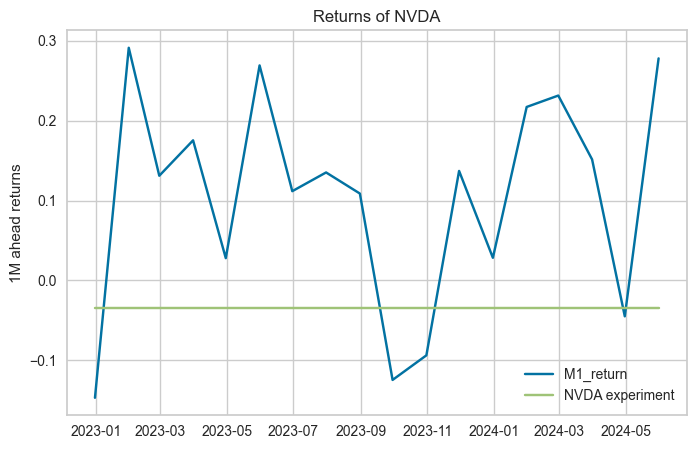

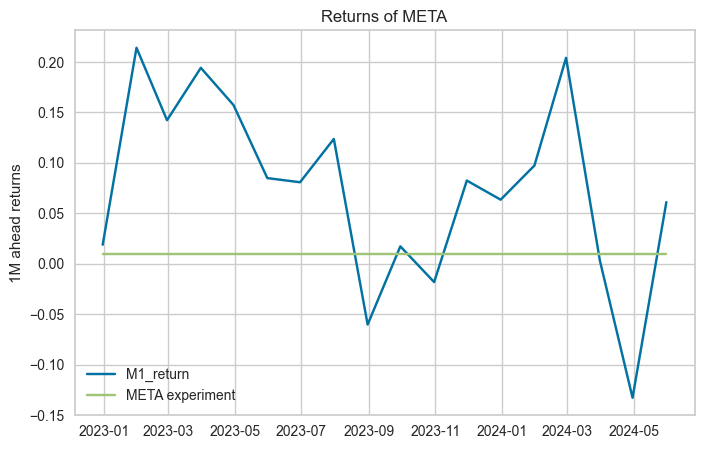

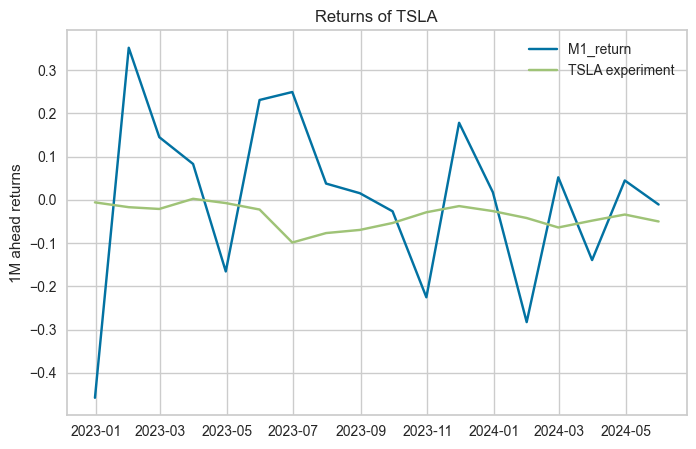

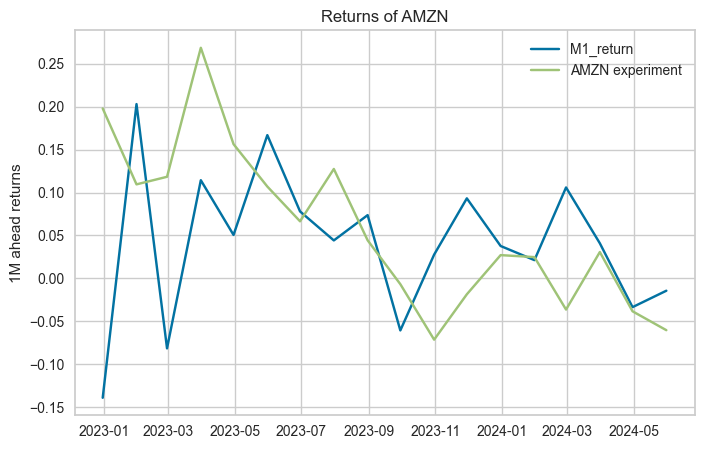

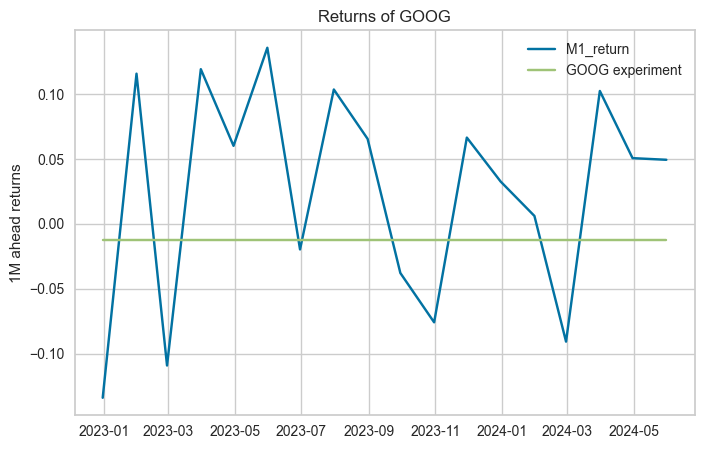

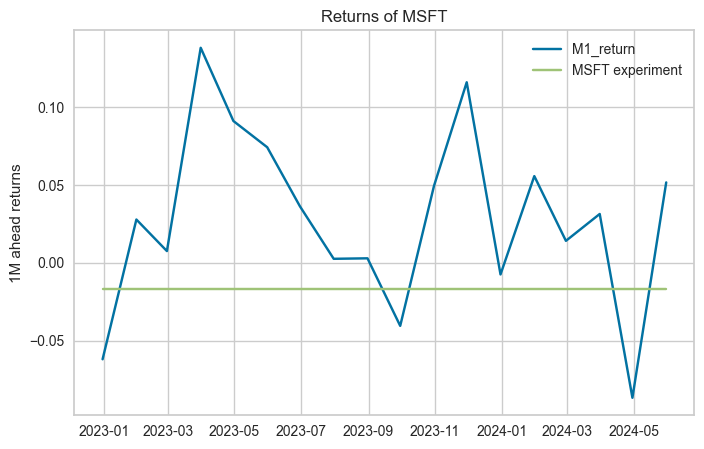

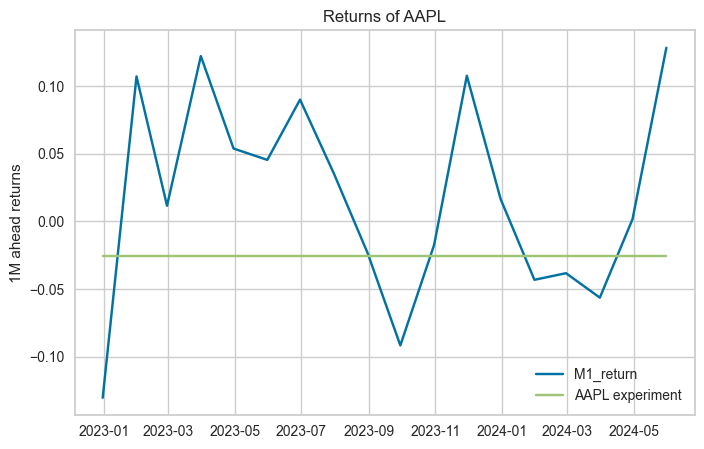

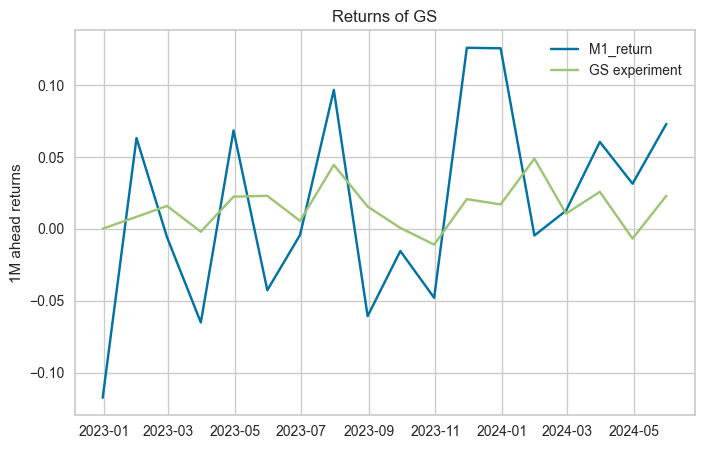

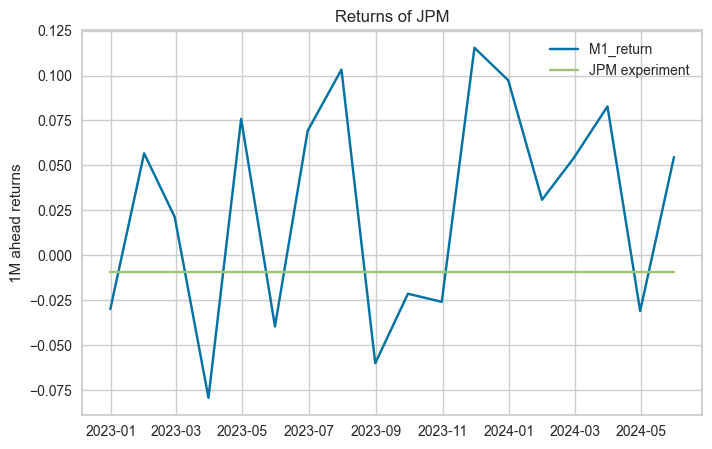

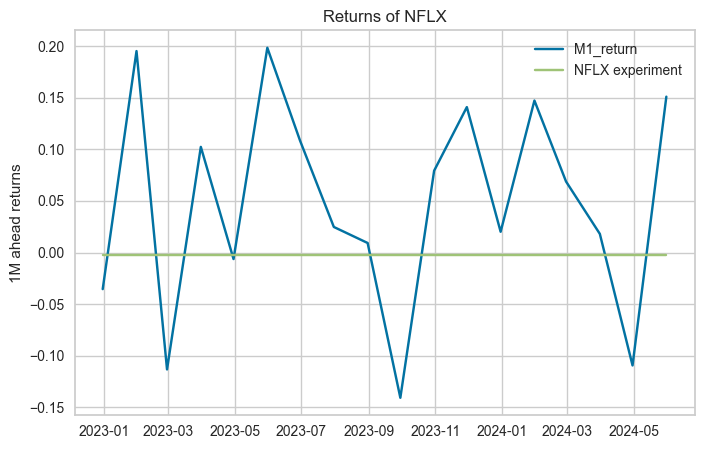

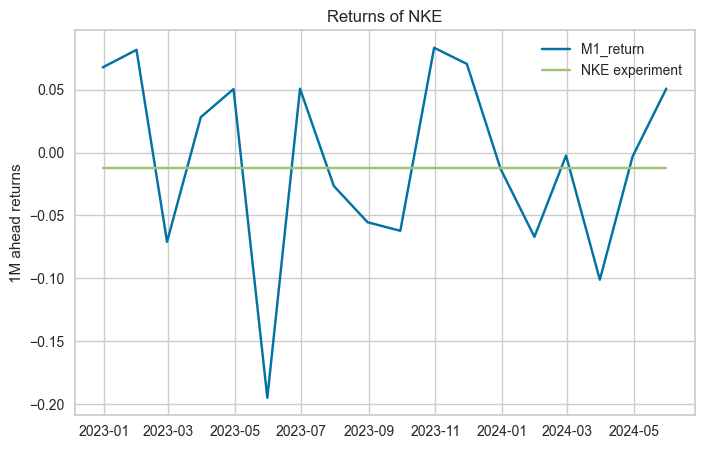

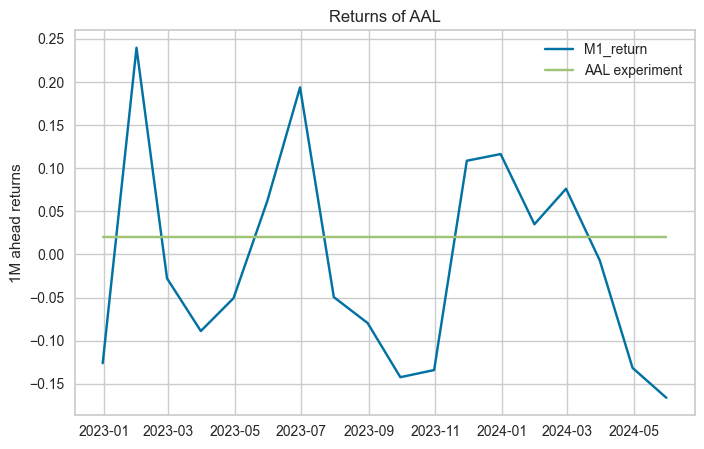

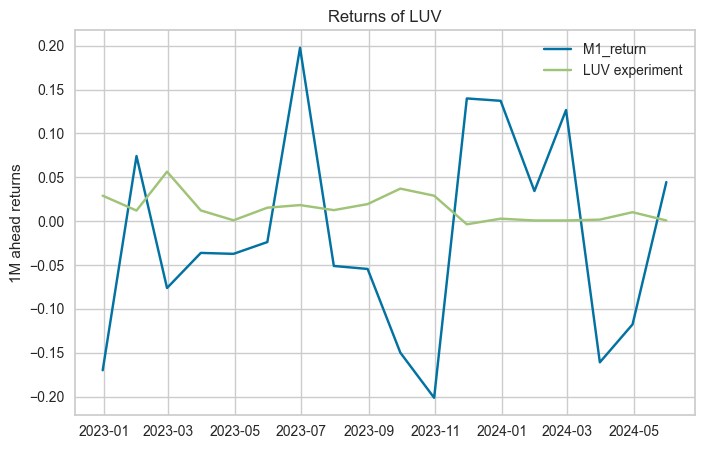

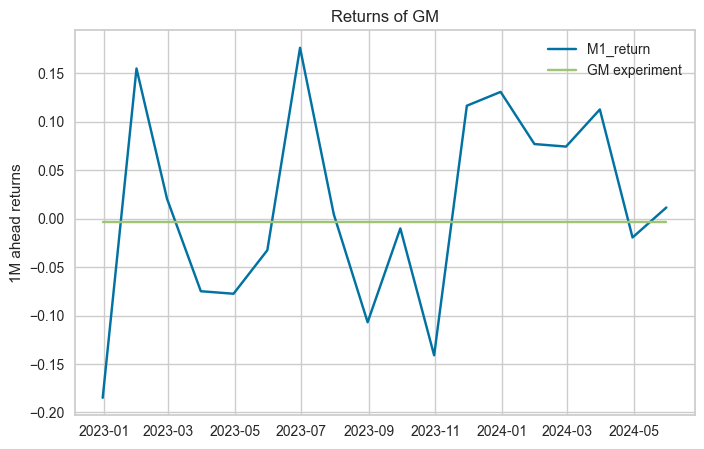

In [18]:
for key,value in Latest_Features.items():
    
    model = setup(Latest_Features[key], target = 'M1_forward_return', fold_strategy = 'timeseries', data_split_shuffle=False, 
                  fold_shuffle=False, transformation = False, transform_target = False ,normalize=True,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95, session_id=123, 
                  log_experiment=False, experiment_name=f'{key} experiment')
    
    best_3model = compare_models(n_select = 3)
    blend = blend_models(best_3model)
    pred_holdouts = predict_model(blend)
    
    # Add trace plot
    plt.figure(figsize=(8,5))
    plt.plot(pred_holdouts['M1_return'])
    plt.plot(pred_holdouts['prediction_label'])
    plt.ylabel("1M ahead returns")
    plt.legend(['M1_return', f'{key} experiment'])
    plt.title(f'Returns of {key}');